# Data Preprocessing 

### sampling the data 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns 
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set_palette('Accent')

In [3]:
DIR_PATH = os.path.join('..', 'data', 'raw')

data = pd.read_csv(os.path.join(DIR_PATH, "MachineLearningCVE.csv"))

In [4]:
data.shape

(2830743, 79)

In [5]:
# Dropping duplicates 
data.drop_duplicates(inplace = True)

# Replacing any infinite values (positive or negative) with NaN (not a number)
data.replace([np.inf, -np.inf], np.nan, inplace = True)

# Filling missing values with median
med_flow_bytes = data['Flow Bytes/s'].median()
med_flow_packets = data['Flow Packets/s'].median()

data['Flow Bytes/s'].fillna(med_flow_bytes, inplace = True)
data['Flow Packets/s'].fillna(med_flow_packets, inplace = True)


In [6]:
# Z-score normalization
features = data.dtypes[data.dtypes != 'object'].index
data[features] = data[features].apply(
    lambda x: (x - x.mean()) / (x.std()))

In [7]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,2.127889,-0.470736,-0.010421,-0.010946,-0.056644,-0.007564,-0.297676,-0.217037,-0.293962,-0.260373,...,0.002697,-0.133328,-0.110847,-0.158407,-0.10708,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN
1,2.127889,-0.470736,-0.010421,-0.010946,-0.056644,-0.007564,-0.297676,-0.217037,-0.293962,-0.260373,...,0.002697,-0.133328,-0.110847,-0.158407,-0.10708,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN
4,2.143553,-0.470736,-0.010421,-0.010946,-0.056644,-0.007564,-0.297676,-0.217037,-0.293962,-0.260373,...,0.002697,-0.133328,-0.110847,-0.158407,-0.10708,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN
5,2.143553,-0.470736,-0.010421,-0.010946,-0.056644,-0.007564,-0.297676,-0.217037,-0.293962,-0.260373,...,0.002697,-0.133328,-0.110847,-0.158407,-0.10708,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN
8,-0.452916,-0.470719,-0.004125,-0.007161,-0.012052,-0.007391,0.002524,-0.315730,0.029016,0.116883,...,0.002697,-0.133328,-0.110847,-0.158407,-0.10708,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN


In [8]:
# Creating a dictionary that maps each label to its attack type
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack-Brute Force': 'Web Attack',
    'Web Attack-XSS': 'Web Attack',
    'Web Attack-Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

# Creating a new column 'Attack Type' in the DataFrame based on the attack_map dictionary
data['Attack Type'] = data['Label'].map(attack_map)

binary_attack = {
    'BENIGN': 0,  # Keep BENIGN as it is
}

# Add all other attack types from attack_map as 'Attack'
for attack_type in attack_map.values():
    if attack_type != 'BENIGN':
        binary_attack[attack_type] = 1

data['Target'] = data['Attack Type'].map(binary_attack)



le = LabelEncoder()
data['Attack Number'] = le.fit_transform(data['Attack Type'])

In [9]:
# Printing corresponding attack type for each encoded value
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: BENIGN
1: Bot
2: Brute Force
3: DoS
4: Heartbleed
5: Infiltration
6: Port Scan
7: Web Attack


In [10]:
# For improving performance and reduce memory-related errors
old_memory_usage = data.memory_usage().sum() / 1024 ** 2
print(f'Initial memory usage: {old_memory_usage:.2f} MB')
for col in data.columns:
    col_type = data[col].dtype
    if col_type != object:
        c_min = data[col].min()
        c_max = data[col].max()
        # Downcasting float64 to float32
        if str(col_type).find('float') >= 0 and c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            data[col] = data[col].astype(np.float32)

        # Downcasting int64 to int32
        elif str(col_type).find('int') >= 0 and c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
            data[col] = data[col].astype(np.int32)

new_memory_usage = data.memory_usage().sum() / 1024 ** 2
print(f"Final memory usage: {new_memory_usage:.2f} MB")

# Calculating percentage reduction in memory usage
print(f'Reduced memory usage: {1 - (new_memory_usage / old_memory_usage):.2%}')

Initial memory usage: 1587.64 MB
Final memory usage: 904.47 MB
Reduced memory usage: 43.03%


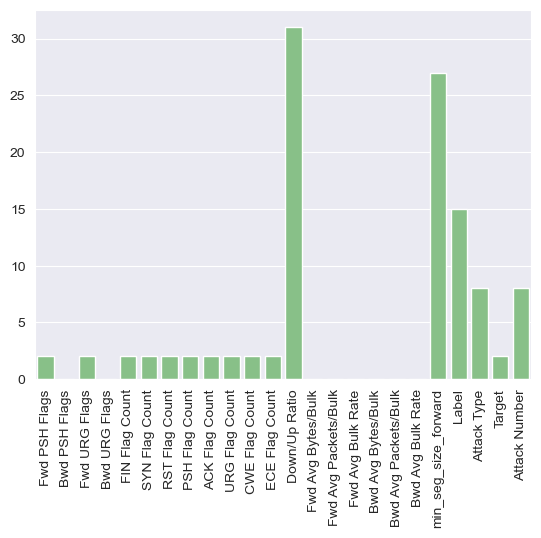

In [11]:
d = {f: data[f].nunique() for f in data.columns if data[f].nunique() < 50}
sns.barplot(d)
plt.xticks(rotation = 90)
plt.show()

'Dropped columns:'

Index([], dtype='object')

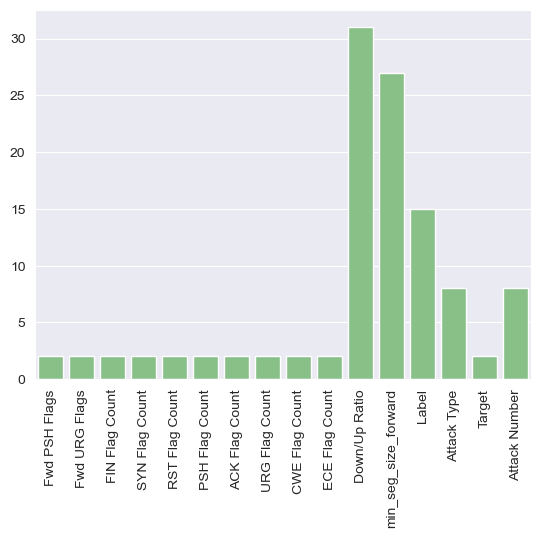

In [12]:
# dropping features with one unique value 
num_unique = data.nunique()
one_variable = num_unique[num_unique == 1]
not_one_variable = num_unique[num_unique > 1].index

dropped_cols = one_variable.index
data = data[not_one_variable]

display('Dropped columns:')
display(dropped_cols)
d = {f: data[f].nunique() for f in data.columns if data[f].nunique() < 50}
sns.barplot(d)
plt.xticks(rotation = 90)
plt.show()

In [13]:
data.shape

(2522362, 74)

In [14]:
#data = data.drop(["Label", "Attack Type", "Attack Number"], axis = 1)
#data.shape

In [15]:
cat_features = [feature for feature in data.columns if data[feature].nunique() < 50]
cat_features

['Fwd PSH Flags',
 'Fwd URG Flags',
 'FIN Flag Count',
 'SYN Flag Count',
 'RST Flag Count',
 'PSH Flag Count',
 'ACK Flag Count',
 'URG Flag Count',
 'CWE Flag Count',
 'ECE Flag Count',
 'Down/Up Ratio',
 'min_seg_size_forward',
 'Label',
 'Attack Type',
 'Target',
 'Attack Number']

In [16]:
for feature in cat_features :
    print(data[feature].value_counts())

Fwd PSH Flags
-0.226352    2399427
 4.417900     122935
Name: count, dtype: int64
Fwd URG Flags
-0.005632      2522282
 177.562698         80
Name: count, dtype: int64
FIN Flag Count
-0.182249    2441276
 5.487006      81086
Name: count, dtype: int64
SYN Flag Count
-0.226352    2399427
 4.417900     122935
Name: count, dtype: int64
RST Flag Count
-0.016494     2521676
 60.629292        686
Name: count, dtype: int64
PSH Flag Count
-0.650789    1771911
 1.536596     750451
Name: count, dtype: int64
ACK Flag Count
-0.673710    1734912
 1.484319     787450
Name: count, dtype: int64
URG Flag Count
-0.335971    2266525
 2.976449     255837
Name: count, dtype: int64
CWE Flag Count
-0.005632      2522282
 177.562698         80
Name: count, dtype: int64
ECE Flag Count
-0.01653     2521673
 60.49712        689
Name: count, dtype: int64
Down/Up Ratio
 0.430801      1541623
-1.006876       905392
 1.868477        48450
 6.181507        10661
 3.306154         6520
 7.619184         6452
 4.743831 

In [17]:
unique_val_count_df = pd.DataFrame()

# Iterate through each categorical feature
for feature in cat_features:
    # Get rows where the value counts for the feature is equal to 1
    unique_rows = data[data[feature].isin(data[feature].value_counts()[data[feature].value_counts() <= 2].index)]
    
    # Append unique rows to the unique_val_count_df, avoiding duplicates
    unique_val_count_df = pd.concat([unique_val_count_df, unique_rows]).drop_duplicates()


In [18]:
unique_val_count_df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Attack Type,Target,Attack Number
430786,-0.434257,-0.469820,-0.011680,0.091269,-0.057211,0.094137,-0.297676,-0.217037,-0.293962,-0.260373,...,-0.158407,-0.107080,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN,BENIGN,0,0
822362,-0.434257,-0.470599,-0.011680,0.015554,-0.057778,0.016461,-0.305611,-0.315730,-0.324653,-0.260373,...,-0.158407,-0.107080,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN,BENIGN,0,0
844414,-0.434257,-0.470047,-0.011680,0.012714,-0.057778,0.013142,-0.305611,-0.315730,-0.324653,-0.260373,...,-0.158407,-0.107080,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN,BENIGN,0,0
863312,-0.434257,-0.470619,-0.011680,0.002304,-0.057778,0.004616,-0.305611,-0.315730,-0.324653,-0.260373,...,-0.158407,-0.107080,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN,BENIGN,0,0
903396,-0.434257,-0.470030,-0.011680,0.022179,-0.057778,0.019506,-0.305611,-0.315730,-0.324653,-0.260373,...,-0.158407,-0.107080,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN,BENIGN,0,0
905466,-0.208081,0.096971,-0.011680,-0.000536,-0.057778,-0.007559,-0.305611,-0.315730,-0.324653,-0.260373,...,-0.158407,-0.107080,0.026907,-0.116044,0.009460,0.045284,BENIGN,BENIGN,0,0
953606,-0.434257,-0.470563,-0.011680,0.019340,-0.057778,0.016461,-0.305611,-0.315730,-0.324653,-0.260373,...,-0.158407,-0.107080,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN,BENIGN,0,0
1541296,-0.434152,-0.299422,-0.011680,0.025965,-0.057211,-0.007466,-0.297676,-0.217037,-0.293962,-0.260373,...,-0.158407,-0.107080,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN,BENIGN,0,0
1558260,-0.434152,-0.299541,-0.011680,0.029750,-0.057211,-0.007456,-0.297676,-0.217037,-0.293962,-0.260373,...,-0.158407,-0.107080,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN,BENIGN,0,0
1558593,-0.434257,-0.470544,-0.011680,0.013661,-0.057211,0.015580,-0.297676,-0.217037,-0.293962,-0.260373,...,-0.158407,-0.107080,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN,BENIGN,0,0


In [19]:
data['Attack Number'].value_counts()

Attack Number
0    2096484
3     321764
6      90819
2       9152
7       2143
1       1953
5         36
4         11
Name: count, dtype: int64

In [20]:
# retain the minority class instances and sample the majority class instances
df_minor = data[(data['Attack Number']==7)|(data['Attack Number']==1)|(data['Attack Number']==5)|(data['Attack Number']==4)]
df_major = data.drop(df_minor.index)

In [21]:
X = df_major.drop(['Attack Number','Label', 'Attack Type', 'Target'],axis=1)
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [22]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [23]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [24]:
df_major['klabel'].value_counts()

klabel
560    17907
164    16921
978    15537
737    13711
28     12147
       ...  
486       59
123       54
158       47
644       14
862        5
Name: count, Length: 999, dtype: int64

In [25]:
cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Attack Number')))
df_major = df_major.loc[:, cols]

In [26]:
df_major.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Attack Type,Target,klabel,Attack Number
0,2.127889,-0.470736,-0.010421,-0.010946,-0.056644,-0.007564,-0.297676,-0.217037,-0.293962,-0.260373,...,-0.10708,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN,BENIGN,0,710,0
1,2.127889,-0.470736,-0.010421,-0.010946,-0.056644,-0.007564,-0.297676,-0.217037,-0.293962,-0.260373,...,-0.10708,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN,BENIGN,0,58,0
4,2.143553,-0.470736,-0.010421,-0.010946,-0.056644,-0.007564,-0.297676,-0.217037,-0.293962,-0.260373,...,-0.10708,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN,BENIGN,0,370,0
5,2.143553,-0.470736,-0.010421,-0.010946,-0.056644,-0.007564,-0.297676,-0.217037,-0.293962,-0.260373,...,-0.10708,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN,BENIGN,0,58,0
8,-0.452916,-0.470719,-0.004125,-0.007161,-0.012052,-0.007391,0.002524,-0.315730,0.029016,0.116883,...,-0.10708,-0.375644,-0.116044,-0.381002,-0.361637,BENIGN,BENIGN,0,433,0


In [27]:
def typicalSampling(group):
    name = group.name
    frac = 0.04
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [28]:
result['Attack Number'].value_counts()

Attack Number
0    83808
3    12897
6     3666
2      363
Name: count, dtype: int64

In [29]:
result.shape

(100734, 75)

In [30]:
result = result.drop(['klabel'],axis=1)
result = pd.concat([result, df_minor], ignore_index=True)

In [31]:
result.shape

(104877, 74)

In [32]:
result['Attack Number'].value_counts()

Attack Number
0    83808
3    12897
6     3666
7     2143
1     1953
2      363
5       36
4       11
Name: count, dtype: int64

In [33]:
result = result.drop(["Label", "Attack Type", "Target"], axis = 1)

result.to_csv(os.path.join(DIR_PATH, "sample_data.csv"), index=0)

In [34]:
sample = pd.read_csv(os.path.join(DIR_PATH, "sample_data.csv"))

In [37]:
data= data.drop(["Label", "Attack Type", "Target"], axis = 1)

In [38]:
def CountClasses(sample, full_data):
    # Get the feature names and unique value counts for both datasets
    features = list(full_data.columns)[:-1]
    sampled_unique_counts = [sample[feature].nunique() for feature in features]
    full_data_unique_counts = [full_data[feature].nunique() for feature in features]

    # Filter for features with less than 50 unique values
    filtered_features = [
        feature for i, feature in enumerate(features)
        if sampled_unique_counts[i] < 50 and full_data_unique_counts[i] < 50
    ]
    filtered_sampled_counts = [
        sampled_unique_counts[i] for i in range(len(features))
        if sampled_unique_counts[i] < 50 and full_data_unique_counts[i] < 50
    ]
    filtered_full_counts = [
        full_data_unique_counts[i] for i in range(len(features))
        if sampled_unique_counts[i] < 50 and full_data_unique_counts[i] < 50
    ]

    return filtered_sampled_counts, filtered_full_counts, filtered_features


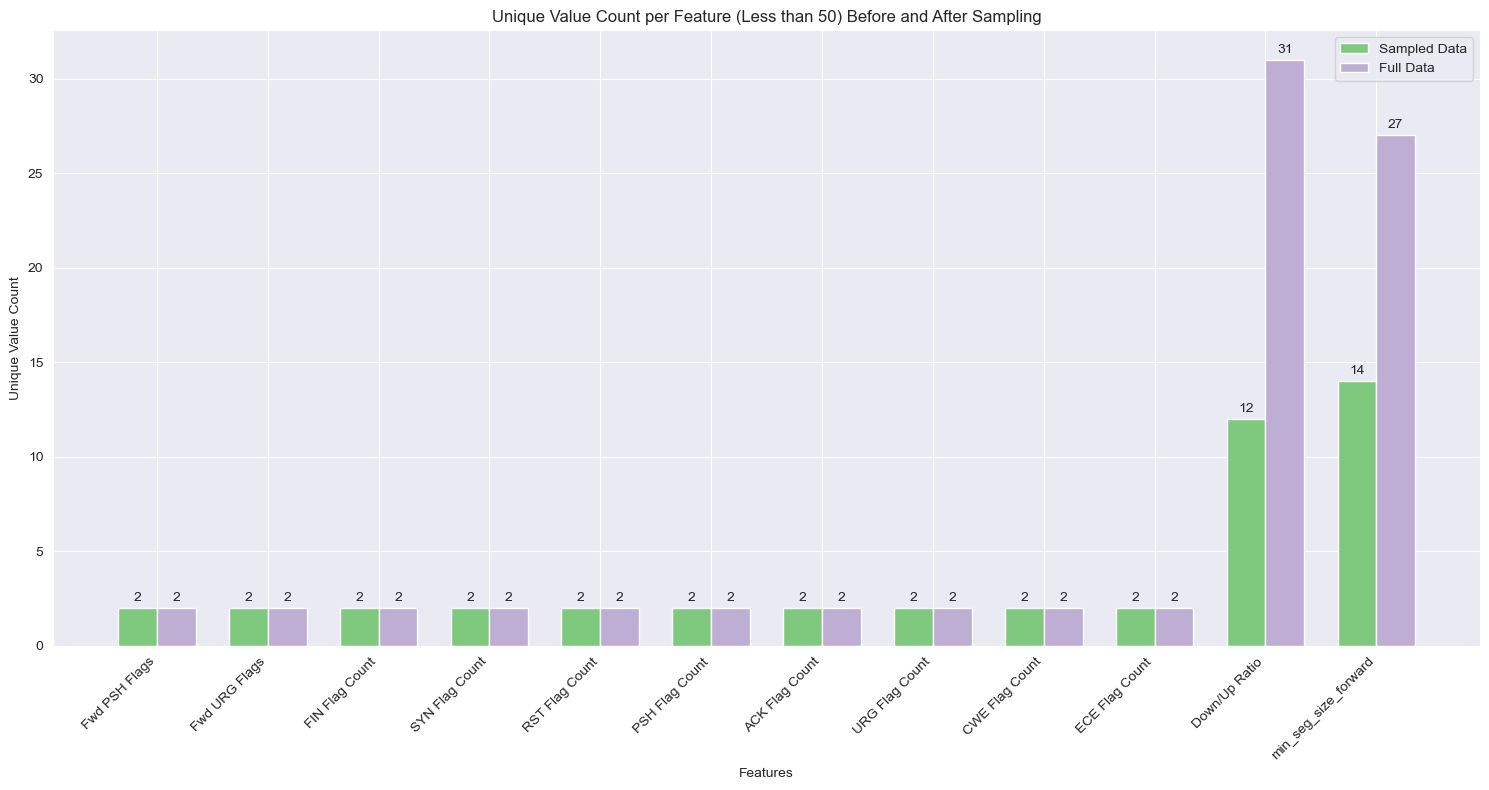

In [39]:
# Sampled and full dataset counts
filtered_sampled_counts, filtered_full_counts, filtered_features = CountClasses(result, data)

# Set the positions and width for the bars
x = np.arange(len(filtered_features))  # label locations
width = 0.35  # Width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot vertical bars for each dataset
rects1 = ax.bar(x - width/2, filtered_sampled_counts, width=width, label='Sampled Data')
rects2 = ax.bar(x + width/2, filtered_full_counts, width=width, label='Full Data')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Features')
ax.set_ylabel('Unique Value Count')
ax.set_title('Unique Value Count per Feature (Less than 50) Before and After Sampling')
ax.set_xticks(x)
ax.set_xticklabels(filtered_features, rotation=45, ha="right")
ax.legend()

# Add a function to label the bars with their heights
def autolabel(rects):
    """Attach a text label above each bar, displaying its height (count)."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',  # Text label (height of the bar)
                    xy=(rect.get_x() + rect.get_width() / 2, height),  # Position at the top of the bar
                    xytext=(0, 3),  # Offset slightly above the bar
                    textcoords="offset points",
                    ha='center', va='bottom')  # Center the label horizontally, place it above the bar

# Apply the autolabel function to all the bar sets
autolabel(rects1)
autolabel(rects2)

# Adjust layout to prevent overlap of x-axis labels
fig.tight_layout()

# Show the plot
plt.show()

* To improve performance and reduce the risk of memory-related errors (mostly session crashes), we downcasted the float and integer values based on the presence of the minimum and maximum values and reduced memory usage by 47.5%.

* The columns with zero standard deviation have the same value in all rows. These columns don't have any variance. It simply means that there is no meaningful relationship with any other columns. These columns cannot help differentiate between the classes or groups of data. So, we dropped the columns that have no variation.

* Created samples to perform feature engineering to reduce computational time